## Language Model

In [4]:
from fastai.text import *
import html
import json

In [ ]:
# If data is downloaded, skip this
# ! mkdir ~/data/happydb
# !  git clone https://github.com/rit-public/HappyDB.git /home/ubuntu/data/happydb/

In [2]:
# If already symlinked, ignore this
# ! ln -s ~/fastai/fastai fastai

# Data Preparation

In [7]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH = Path("/home/ubuntu/data/happydb/happydb/")

LM_PATH=PATH/'happydb_lm'
LM_PATH.mkdir(exist_ok=True)

In [10]:
LANG_TEXT = pd.read_csv(str(PATH/'data'/'cleaned_hm.csv'))
LANG_TEXT.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [13]:
pd.crosstab(LANG_TEXT.ground_truth_category, LANG_TEXT.predicted_category)

predicted_category,achievement,affection,bonding,enjoy_the_moment,exercise,leisure,nature
ground_truth_category,,,,,,,
achievement,4142,75,9,34,3,13,0
affection,12,4777,17,4,0,0,0
bonding,11,39,1691,5,4,0,0
enjoy_the_moment,93,21,3,1351,0,45,1
exercise,7,1,1,0,206,2,0
leisure,31,11,3,52,1,1206,2
nature,0,0,0,2,0,0,250


In [14]:
LANG_TEXT = (LANG_TEXT
     .assign(labels = 0)
     .rename(columns={'cleaned_hm': 'text'})
     .pipe(lambda x: x[['labels', 'text']]))

In [16]:
LANG_TEXT.to_csv(f"{LM_PATH}/corpus.csv", index=False)

# Some statistics about the corpus

In [17]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/corpus.csv")
LANG_TEXT.head()

,labels,text
0,0,I went on a successful date with someone I fel...
1,0,I was happy when my son got 90% marks in his e...
2,0,I went to the gym this morning and did yoga.
3,0,We had a serious talk with some friends of our...
4,0,I went with grandchildren to butterfly display...


## Number of documents

In [18]:
LANG_TEXT.shape

(100535, 2)

## Number of tokens in our corpus

In [19]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

1863638

## Number of unique tokens in our corpus

In [20]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

88048

In [21]:
import re
re1 = re.compile(r'  +')
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))


def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

## Split data into train and validation sets

In [22]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    LANG_TEXT, test_size=0.2) # split the data into train and validation sets

In [23]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text']
df_val.columns = ['labels', 'text']

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False) # saving the data in our new format to disk

In [24]:
chunksize = 10000
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

## Tokenization the training and validation sets

In [26]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
7
0
1
2


## Storing these tokens in numpy arrays

In [27]:
# create a tmp directory to store the upcoming numpy arrays
(LM_PATH/'tmp').mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [28]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [29]:
# Identify the most common tokens and numericalizing the text
freq = Counter(p for o in tok_trn for p in o) 
freq.most_common(25)

[('.', 79213),
 ('i', 75367),
 ('1', 70753),
 ('\n', 70428),
 ('xbos', 70428),
 ('xfld', 70428),
 ('my', 51562),
 ('a', 50127),
 ('to', 39925),
 ('and', 39570),
 ('the', 36482),
 ('was', 24117),
 (',', 22764),
 ('t_up', 19996),
 ('for', 18988),
 ('in', 18464),
 ('me', 17925),
 ('of', 17728),
 ('that', 15888),
 ('with', 15653),
 ('it', 14206),
 ('happy', 13177),
 ('on', 10789),
 ('got', 9388),
 ('had', 9280)]

## Truncating our corpus to exclude rare words

In [30]:
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

## Create a index2string (itos) and string2index (stoi) representation

In [31]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

6880

In [32]:
list(stoi.keys())[0:10]

['_unk_', '_pad_', '.', 'i', '1', '\n', 'xbos', 'xfld', 'my', 'a']

## Create an index representation for train and validation dataset

In [33]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [34]:
# Save them to disk for future purposes
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [35]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [36]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

(6880, 70428)

## Language model tokens

In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. Use the awesome [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive

## wikitext103 conversion

We are now going to build an english language model for the EDGAR corpus. We could start from scratch and try to learn the structure of the english language. But we use a technique called transfer learning to make this process easier. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(_like wikipedia articles_) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the EDGAR LM. 

In [37]:
if not (PATH/'models').exists():
    ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

--2018-06-02 17:01:10--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘/home/ubuntu/data/happydb/happydb/models/wt103/index.html’

models/wt103/index. 100%[===================>]     857  --.-KB/s    in 0s      

2018-06-02 17:01:10 (130 MB/s) - ‘/home/ubuntu/data/happydb/happydb/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2018-06-02 17:01:10--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2018-06-02 17:01:10 ERROR 404: Not Found.

--2018-06-02 17:01:10--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘/home/ubuntu/data/happydb/ha

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values with the target EDGAR LM so that the weights can be loaded up.

In [38]:
em_sz, nh, nl = 400, 1150, 3

In [39]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [40]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target EDGAR LM.

In [41]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [42]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the EDGAR LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown EDGAR tokens that do not exist in wikitext103.

In [43]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [44]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new EDGAR language pytorch model!

## Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the EDGAR LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

In [45]:
wd=1e-7
bptt=10
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [46]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [47]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

## Finetune the last embedding layer first. Then tune everything else.
We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [94]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip = 1
learner.freeze_to(-1)

In [95]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our EDGAR LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [50]:
lr=1e-3
lrs = lr

### NOTE: 
- bptt is by far the most important parameter here. Tune it according to the corpus.

In [68]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      3.534831   3.309241   0.384478  



[array([3.30924]), 0.3844779326185303]

In [69]:
learner.save('lm_last_ft')

In [53]:
learner.load('lm_last_ft')

In [103]:
learner.unfreeze()

In [105]:
learner.lr_find(start_lr=1e-5, end_lr=1e-2)#, linear=True)

epoch      trn_loss   val_loss   accuracy   
    0      3.567634   3.477324   0.369755  


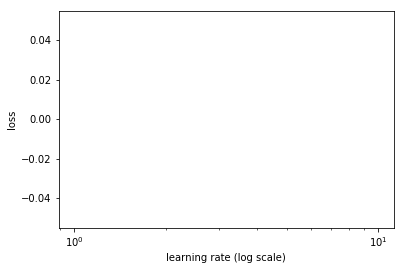

 80%|███████▉  | 2636/3305 [01:00<00:15, 43.93it/s, loss=13.6]

In [99]:
learner.sched.plot(n_skip=0, n_skip_end=0)

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr_beta=(20,10, 0.95, 0.85), cycle_len=15)

epoch      trn_loss   val_loss   accuracy   
    0      3.134434   2.985985   0.423782  
    1      2.97736    2.826085   0.444575  
    2      2.890965   2.746344   0.456952  
    3      2.767016   2.710781   0.464012  
    4      2.765686   2.697728   0.466487  
    5      2.682429   2.701446   0.46787   
    6      2.643462   2.711063   0.467869  
    7      2.630259   2.690388   0.472232  
 92%|█████████▏| 3051/3305 [01:07<00:05, 45.23it/s, loss=2.46]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [47]:
learner.save('lm_edgar1') # Save the model weights
learner.save_encoder('lm_edgar1_enc') # Save just the encoder weights

# Inference

### Generate text

In [54]:
learner.load("lm_last_ft")

In [70]:
m = learner.model

In [111]:
m[0].bs = 1
m.eval()

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(111, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(111, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=111, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [71]:
m.eval()

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(6880, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(6880, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=6880, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [72]:
sen = "park"
idxs = np.array([stoi[c] for c in sen.split(" ")])
idxs

array([288])

In [73]:
idxs = np.array([stoi[c] for c in sen.split(" ")])

In [74]:
VV(T([idxs]))

Variable containing:
 288
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

In [76]:
# m(VV(T([idxs])))

In [77]:
def get_next(inp):
    #m[0].bs = 1
    idxs = np.array([stoi[c] for c in inp.split(" ")])
    p = m(VV(T([idxs])))
    i = np.argmax(to_np(p)[0])
    return itos[i]

def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        #print("input:", inp, "| output:", c)
        res = res + ' ' + c
        inp = c
    return res

In [63]:
m = learner.model
m.eval()
m[0].bs = 1

In [79]:
sen = """cute"""
get_next(sen)

','

In [80]:
sen = """dog"""
get_next(sen)

'.'

In [85]:
m.reset()

In [86]:
sen = """session"""
get_next(sen)

'.'

In [59]:
sen = """the"""
get_next(sen)

'board'

In [60]:
sen = """board"""
get_next(sen)

'of'

In [61]:
sen = "unanimous"
get_next_n(sen, 10)

'unanimous consent of the board of directors of the company .'

In [62]:
sen = "the"
get_next_n(sen, 10)

'the board of directors of _unk_ _unk_ \n _unk_ _unk_ ,'

### Generation of text for multiple input tokens

In [120]:
def get_next2(inp):
    idxs = np.array([stoi[c] for c in inp.split(" ")])
    p = m(VV(T([idxs])))
    i = np.argmax(to_np(p)[0][-1])
    return itos[i]

def get_next_n2(inp, n):
    res = inp
    for i in range(n):
        c = get_next2(inp)
        #print("input:", inp, "| output:", c)
        res = res + ' ' + c
        inp = c
    return res

In [64]:
sen = "unanimous consent"
idxs = np.array([stoi[c] for c in sen.split(" ")])
idxs

array([15, 10])

In [66]:
idxs = np.array([stoi[c] for c in sen.split(" ")])
idxs

array([15, 10])

In [67]:
VV(T([idxs]))

Variable containing:
 15  10
[torch.cuda.LongTensor of size 1x2 (GPU 0)]

In [70]:
p = m(VV(T([idxs])))
len(p)

3

In [84]:
itos[np.argmax(to_np(p)[0][-1])]

'to'

In [87]:
sen = """unanimous consent"""
get_next2(sen)

'to'

In [90]:
sen = """the board"""
get_next2(sen)

'of'

In [91]:
sen = """to of"""
get_next2(sen)

'directors'

In [92]:
sen = """of directors"""
get_next2(sen)

'.'

In [93]:
sen = """big board"""
get_next2(sen)

'of'

In [94]:
sen = """the board directors"""
get_next2(sen)

'of'

In [119]:
sen = """unanimous consent of the board"""
get_next2(sen)

'.'

In [125]:
sen = """unanimous consent"""
get_next_n2(sen, 10)

'unanimous consent to the _unk_ of the _unk_ _unk_ , \n which'

In [126]:
sen = """the board"""
get_next_n2(sen, 10)

'the board of the board of directors ( the “ board ”'

In [127]:
sen = """unanimous consent of"""
get_next_n2(sen, 10)

'unanimous consent of the following _unk_ - _unk_ , _unk_ , _unk_ _unk_'

In [128]:
sen = """the"""
get_next_n2(sen, 30)

'the \n _unk_ of _unk_ _unk_ , _unk_ . the _unk_ _unk_ of the _unk_ _unk_ , was _unk_ approved by the unanimous consent of the board of directors . \n '

### Generation of text for multiple sentences

In [209]:
def get_next3(inp):
    #idxs = np.array([stoi[c] for c in inp.split(" ")])
    idxs = np.array([[stoi[c] for c in s.split(' ')] for s in sen])
    p = m(*VV(T([idxs])))
    #i = np.argmax(to_np(p)[0][-1])
    i = [itos[x[0]] for x in to_np(torch.topk(p[0].view(2,3,-1), 1)[1][:,2])]
    return i

def get_next_n3(inp, n):
    res = inp
    for i in range(n):
        c = get_next3(inp)
        #print("input:", inp, "| output:", c)
        res = res + ' ' + c
        inp = c
    return res

In [170]:
sen = ["""unanimous consent of""", "the board of"]

array([[15, 10,  2],
       [ 3,  9,  2]])

In [175]:
VV(T([idxs]))

Variable containing:
(0 ,.,.) = 
  15  10   2
   3   9   2
[torch.cuda.LongTensor of size 1x2x3 (GPU 0)]

In [176]:
p = m(*VV(T([idxs])))
len(p)

3

In [254]:
p[-1][-1].mean(0)

Variable containing:
 1.7778e-01  1.0758e-01  5.3058e-01  ...   1.4191e-01  1.2087e-01 -7.0450e-01
 1.6380e-01  6.6716e-02  2.4360e-01  ...  -2.4408e-01 -1.3029e-01 -8.8590e-02
 4.6984e-01  3.5394e-02 -1.0065e-01  ...   1.4377e-01 -6.1673e-03  4.0824e-01
[torch.cuda.FloatTensor of size 3x400 (GPU 0)]

In [159]:
np.argmax(to_np(p)[0], axis=1)

array([10, 12,  3, 10,  2,  3])

In [160]:
[itos[x] for x in np.argmax(to_np(p)[0], axis=1)]

['consent', 'to', 'the', 'consent', 'of', 'the']

In [276]:
sen = ["""unanimous consent of""", "the board of"]
get_next3(sen)

['the', 'the']

In [273]:
sen = ["""unanimous consent the""", "the board of"]
get_next3(sen)

['following', 'the']

In [269]:
sen = ["""the board of""", "unanimous consent of"]
get_next3(sen)

['directors', 'directors']

In [277]:
sen = ["""of the board""", "unanimous consent of"]
get_next3(sen)

['of', 'directors']

In [275]:
m.reset() # To reset (clear) model state (because its a stateful model) - Just being cautious. Do this once in a while.

### Extract hidden state for sentence embeddings to measure similarity

In [359]:
def get_sentence_embedding(inp):
    idxs = np.array([stoi[c] for c in inp.split(" ")])
    p = m(VV(T([idxs])))
    i = p[-1][-1] # Access the last hidden layer of size 400
    i = to_np(i.mean(0).mean(0)) # Take the mean embedding of the entire sentence
    return i

In [360]:
sen1 = """unanimous consent of board"""
sen_emb1 = get_sentence_embedding(sen1)
sen_emb1.shape

(400,)

In [361]:
sen2 = """Hey I am going out"""
sen_emb2 = get_sentence_embedding(sen2)

In [362]:
sen3 = """of directors members"""
sen_emb3 = get_sentence_embedding(sen3)

In [363]:
sen4 = """board directors"""
sen_emb4 = get_sentence_embedding(sen4)

In [377]:
def get_similarity(doc_emb1, doc_emb2, method='cosine'):
    if method == 'cosine':
        return np.dot(doc_emb1, doc_emb2) / (np.sqrt(np.sum(np.power(doc_emb1, 2))) * np.sqrt(np.sum(np.power(doc_emb2, 2))))
    else:
        return np.sqrt(np.sum(np.power((doc_emb1 - doc_emb2), 2)))

In [379]:
get_similarity(sen_emb1, sen_emb2, 'euclidean'), get_similarity(sen_emb1, sen_emb2, 'cosine')

(3.1782005, 0.1707655)

In [380]:
get_similarity(sen_emb1, sen_emb3, 'euclidean'), get_similarity(sen_emb1, sen_emb3, 'cosine')

(2.5659351, 0.29153135)

In [381]:
get_similarity(sen_emb1, sen_emb4, 'euclidean'), get_similarity(sen_emb1, sen_emb4, 'cosine')

(2.3731213, 0.56092036)

In [382]:
get_similarity(sen_emb3, sen_emb4, 'euclidean'), get_similarity(sen_emb3, sen_emb4, 'cosine')

(1.9308287, 0.61797893)